In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import preprocessing as proc

from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, roc_auc_score, auc, average_precision_score, classification_report
from sklearn.metrics import det_curve, roc_curve, precision_recall_curve, confusion_matrix
from sklearn.metrics import PrecisionRecallDisplay, RocCurveDisplay, DetCurveDisplay, ConfusionMatrixDisplay
from imblearn.pipeline import Pipeline
#from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTE

import joblib

pd.pandas.set_option('display.max_columns', None)

In [2]:
df = pd.read_csv('carclaims.csv')
print(df.shape)
df.head()

(15420, 33)


,Month,WeekOfMonth,DayOfWeek,Make,AccidentArea,DayOfWeekClaimed,MonthClaimed,WeekOfMonthClaimed,Sex,MaritalStatus,Age,Fault,PolicyType,VehicleCategory,VehiclePrice,PolicyNumber,RepNumber,Deductible,DriverRating,Days:Policy-Accident,Days:Policy-Claim,PastNumberOfClaims,AgeOfVehicle,AgeOfPolicyHolder,PoliceReportFiled,WitnessPresent,AgentType,NumberOfSuppliments,AddressChange-Claim,NumberOfCars,Year,BasePolicy,FraudFound
0,Dec,5,Wednesday,Honda,Urban,Tuesday,Jan,1,Female,Single,21,Policy Holder,Sport - Liability,Sport,"more than 69,000",1,12,300,1,more than 30,more than 30,none,3 years,26 to 30,No,No,External,none,1 year,3 to 4,1994,Liability,No
1,Jan,3,Wednesday,Honda,Urban,Monday,Jan,4,Male,Single,34,Policy Holder,Sport - Collision,Sport,"more than 69,000",2,15,400,4,more than 30,more than 30,none,6 years,31 to 35,Yes,No,External,none,no change,1 vehicle,1994,Collision,No
2,Oct,5,Friday,Honda,Urban,Thursday,Nov,2,Male,Married,47,Policy Holder,Sport - Collision,Sport,"more than 69,000",3,7,400,3,more than 30,more than 30,1,7 years,41 to 50,No,No,External,none,no change,1 vehicle,1994,Collision,No
3,Jun,2,Saturday,Toyota,Rural,Friday,Jul,1,Male,Married,65,Third Party,Sedan - Liability,Sport,"20,000 to 29,000",4,4,400,2,more than 30,more than 30,1,more than 7,51 to 65,Yes,No,External,more than 5,no change,1 vehicle,1994,Liability,No
4,Jan,5,Monday,Honda,Urban,Tuesday,Feb,2,Female,Single,27,Third Party,Sport - Collision,Sport,"more than 69,000",5,3,400,1,more than 30,more than 30,none,5 years,31 to 35,No,No,External,none,no change,1 vehicle,1994,Collision,No


In [3]:
X = df.drop(['PolicyNumber', 'FraudFound'], axis=1)
y = df['FraudFound']
print(X.shape, y.shape)
X.head()

(15420, 31) (15420,)


,Month,WeekOfMonth,DayOfWeek,Make,AccidentArea,DayOfWeekClaimed,MonthClaimed,WeekOfMonthClaimed,Sex,MaritalStatus,Age,Fault,PolicyType,VehicleCategory,VehiclePrice,RepNumber,Deductible,DriverRating,Days:Policy-Accident,Days:Policy-Claim,PastNumberOfClaims,AgeOfVehicle,AgeOfPolicyHolder,PoliceReportFiled,WitnessPresent,AgentType,NumberOfSuppliments,AddressChange-Claim,NumberOfCars,Year,BasePolicy
0,Dec,5,Wednesday,Honda,Urban,Tuesday,Jan,1,Female,Single,21,Policy Holder,Sport - Liability,Sport,"more than 69,000",12,300,1,more than 30,more than 30,none,3 years,26 to 30,No,No,External,none,1 year,3 to 4,1994,Liability
1,Jan,3,Wednesday,Honda,Urban,Monday,Jan,4,Male,Single,34,Policy Holder,Sport - Collision,Sport,"more than 69,000",15,400,4,more than 30,more than 30,none,6 years,31 to 35,Yes,No,External,none,no change,1 vehicle,1994,Collision
2,Oct,5,Friday,Honda,Urban,Thursday,Nov,2,Male,Married,47,Policy Holder,Sport - Collision,Sport,"more than 69,000",7,400,3,more than 30,more than 30,1,7 years,41 to 50,No,No,External,none,no change,1 vehicle,1994,Collision
3,Jun,2,Saturday,Toyota,Rural,Friday,Jul,1,Male,Married,65,Third Party,Sedan - Liability,Sport,"20,000 to 29,000",4,400,2,more than 30,more than 30,1,more than 7,51 to 65,Yes,No,External,more than 5,no change,1 vehicle,1994,Liability
4,Jan,5,Monday,Honda,Urban,Tuesday,Feb,2,Female,Single,27,Third Party,Sport - Collision,Sport,"more than 69,000",3,400,1,more than 30,more than 30,none,5 years,31 to 35,No,No,External,none,no change,1 vehicle,1994,Collision


In [4]:
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                   test_size=0.2, 
                                                   random_state=42,
                                                   stratify=y)
X_train.shape, X_test.shape

((12336, 31), (3084, 31))

In [5]:
X_train.reset_index(drop=True, inplace=True)
X_test.reset_index(drop=True, inplace=True)
y_train.reset_index(drop=True, inplace=True)
y_test.reset_index(drop=True, inplace=True)

In [6]:
label_encode = LabelEncoder()
y_train_enc = label_encode.fit_transform(y_train)
y_test_enc = label_encode.transform(y_test)

#### Variables

In [7]:
TEMP_VAR = ['Month', 'MonthClaimed', 'DayOfWeek', 'DayOfWeekClaimed']

NUMERICAL = ['Year', 'Deductible']

ONE_HOT_CATEGORICAL = ['Make', 'PolicyType', 'MaritalStatus',
                       'BasePolicy','Fault', 'Sex', 'AccidentArea']
ORDINAL_CATEGORICAL = ['AgeOfVehicle', 'AgeOfPolicyHolder', 'VehiclePrice',
                       'AddressChange-Claim','NumberOfSuppliments', 'PastNumberOfClaims']

AGE_OF_VEH_VAR = ['AgeOfVehicle']
AGE_OF_POL_VAR = ['AgeOfPolicyHolder']
VEH_PRICE_VAR = ['VehiclePrice']
ADD_CHANGE_VAR = ['AddressChange-Claim']
NUM_SUPP_VAR = ['NumberOfSuppliments']
PAST_CLAIM_VAR = ['PastNumberOfClaims']

MONTH_MAP = {'Jan': 1, 'Feb': 2, 'Mar': 3, 'Apr': 4, 'May': 5, 'Jun': 6, 'Jul': 7, 'Aug': 8, 'Sep': 9, 'Oct': 10, 'Nov': 11, 'Dec': 12}
DAY_MAP = {'Sunday': 6, 'Monday': 0, 'Tuesday': 1, 'Wednesday': 2, 'Thursday': 3, 'Friday': 4, 'Saturday': 5}

AGE_OF_VEH_MAP = {'new': 8, '2 years': 7, '3 years': 6, '4 years': 5,
                  '5 years': 4, '6 years': 3, '7 years': 2, 'more than 7': 1}
AGE_OF_POL_MAP = {'16 to 17': 1, '18 to 20': 2, '21 to 25': 3, '26 to 30': 4,
                  '31 to 35': 5, '36 to 40': 6, '41 to 50': 7, '51 to 65': 8,
                  'over 65': 9}
VEH_PRICE_MAP = {'less than 20,000': 1, '20,000 to 29,000': 2,
                 '30,000 to 39,000': 3, '40,000 to 59,000': 4,
                 '60,000 to 69,000': 5, 'more than 69,000': 6}

ADD_CHANGE_MAP = {'no change': 1, 'under 6 months': 2, '1 year': 3,
                  '2 to 3 years': 4, '4 to 8 years': 5}
NUM_SUPP_MAP = {'none': 1, '1 to 2': 2, '3 to 5': 3, 'more than 5': 4}
PAST_CLAIM_MAP = {'none': 1, '1': 2, '2 to 4': 3, 'more than 4': 4}

In [8]:
FEATURES = [
    'BasePolicy', 'PolicyType', 'Make', 'AccidentArea', 'Fault', 'AgeOfVehicle', 'VehiclePrice', 
    'Year', 'Month', 'MonthClaimed', 'DayOfWeek', 'DayOfWeekClaimed', 'Sex', 'MaritalStatus', 'AgeOfPolicyHolder',
    'Deductible','AddressChange-Claim', 'NumberOfSuppliments', 'PastNumberOfClaims'
]

In [9]:
X_train = X_train[FEATURES]
X_test = X_test[FEATURES]

X_train.shape, X_test.shape

((12336, 19), (3084, 19))

#### Pipeline

In [10]:
# column transformers for Random Forest (One Hot Encoding + Scaling)
col_transform = ColumnTransformer(
    transformers=[
    ('map_month', proc.MapTransform(variable=TEMP_VAR[:2], mappings=MONTH_MAP), TEMP_VAR[:2]),
    ('map_day', proc.MapTransform(variable=TEMP_VAR[2:], mappings=DAY_MAP), TEMP_VAR[2:]),
    ('age_veh', proc.MapTransform(variable=AGE_OF_VEH_VAR, mappings=AGE_OF_VEH_MAP), AGE_OF_VEH_VAR),
    ('age_pol', proc.MapTransform(variable=AGE_OF_POL_VAR, mappings=AGE_OF_POL_MAP), AGE_OF_POL_VAR),
    ('veh_price', proc.MapTransform(variable=VEH_PRICE_VAR, mappings=VEH_PRICE_MAP), VEH_PRICE_VAR),
    ('add_change', proc.MapTransform(variable=ADD_CHANGE_VAR, mappings=ADD_CHANGE_MAP), ADD_CHANGE_VAR),
    ('num_supp', proc.MapTransform(variable=NUM_SUPP_VAR, mappings=NUM_SUPP_MAP), NUM_SUPP_VAR),
    ('past_claim', proc.MapTransform(variable=PAST_CLAIM_VAR, mappings=PAST_CLAIM_MAP), PAST_CLAIM_VAR),
    ('hot_cat', OneHotEncoder(sparse_output=False, handle_unknown='infrequent_if_exist'), ONE_HOT_CATEGORICAL)
    ], remainder='passthrough'
).set_output(transform='pandas')

In [11]:
# clean -> map -> cos/sin -> drop -> onehot -> sampling -> classify
pipeline = Pipeline([
    ('clean', proc.CleanTransform(variable=TEMP_VAR)),
    ('transform', col_transform),
    ('undersamp', RandomUnderSampler(random_state=42, sampling_strategy=0.2)),
    ('reindex', proc.ResetIndexTransform()),
    ('oversamp', SMOTE(random_state=42, sampling_strategy=0.75)),
    ('cos_sin_transform', proc.CoSineTransform(['map_month__Month', 'map_month__MonthClaimed',
       'map_day__DayOfWeek', 'map_day__DayOfWeekClaimed'])),
    ('drop', proc.DropTransform(['map_month__Month', 'map_month__MonthClaimed',
       'map_day__DayOfWeek', 'map_day__DayOfWeekClaimed'])),
    ('classifier', RandomForestClassifier(n_estimators=600, random_state=42, oob_score=True, class_weight='balanced', 
                                          min_samples_leaf=5, min_samples_split=15, max_depth=40))
])

In [12]:
pipeline.fit(X_train, y_train_enc)

c:\Users\zyrvs\Desktop\insurance-fraud-pipeline\venv\lib\site-packages\sklearn\compose\_column_transformer.py:1667: FutureWarning: 
The format of the columns of the 'remainder' transformer in ColumnTransformer.transformers_ will change in version 1.7 to match the format of the other transformers.
At the moment the remainder columns are stored as indices (of type int). With the same ColumnTransformer configuration, in the future they will be stored as column names (of type str).
To use the new behavior now and suppress this warning, use ColumnTransformer(force_int_remainder_cols=False).

  warnings.warn(


Pipeline(steps=[('clean',
                 CleanTransform(variable=['Month', 'MonthClaimed', 'DayOfWeek',
                                          'DayOfWeekClaimed'])),
                ('transform',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('map_month',
                                                  MapTransform(mappings={'Apr': 4,
                                                                         'Aug': 8,
                                                                         'Dec': 12,
                                                                         'Feb': 2,
                                                                         'Jan': 1,
                                                                         'Jul': 7,
                                                                         'Jun': 6,
                                                                         'Mar': 3,
                                                                         'May': 5,
                                                                         'Nov': 11,
                                                                         'Oct': 10,
                                                                         'Sep': 9},
                                                               variable=['Month',
                                                                         'MonthClaimed']),
                                                  ['M...
                                           'map_month__MonthClaimed',
                                           'map_day__DayOfWeek',
                                           'map_day__DayOfWeekClaimed'])),
                ('drop',
                 DropTransform(variable=['map_month__Month',
                                         'map_month__MonthClaimed',
                                         'map_day__DayOfWeek',
                                         'map_day__DayOfWeekClaimed'])),
                ('classifier',
                 RandomForestClassifier(class_weight='balanced', max_depth=40,
                                        min_samples_leaf=5,
                                        min_samples_split=15, n_estimators=600,
                                        oob_score=True, random_state=42))])

#### Evaluation

In [13]:
pred_train = pipeline.predict(X_train)
pred_test = pipeline.predict(X_test)

Accuracy

In [14]:
acc_train = accuracy_score(y_train_enc, pred_train)
print(f'train accuracy: {acc_train}')

train accuracy: 0.8668125810635539


In [15]:
acc_test = accuracy_score(y_test_enc, pred_test)
print(f'test accuracy: {acc_test}')

test accuracy: 0.8505188067444877


Classification report

In [16]:
print(classification_report(y_train_enc, pred_train, target_names=['Not Fraud', 'Fraud']))

              precision    recall  f1-score   support

   Not Fraud       0.97      0.88      0.93     11598
       Fraud       0.25      0.63      0.36       738

    accuracy                           0.87     12336
   macro avg       0.61      0.75      0.64     12336
weighted avg       0.93      0.87      0.89     12336



In [17]:
print(classification_report(y_test_enc, pred_test, target_names=['Not Fraud', 'Fraud']))

              precision    recall  f1-score   support

   Not Fraud       0.96      0.88      0.92      2899
       Fraud       0.19      0.45      0.27       185

    accuracy                           0.85      3084
   macro avg       0.58      0.66      0.59      3084
weighted avg       0.92      0.85      0.88      3084



ROC Curve and AUC

In [18]:
fpr_train, tpr_train, thresholds_train = roc_curve(y_train_enc, pipeline.predict_proba(X_train)[:, 1], pos_label=1)
roc_auc_train = roc_auc_score(y_train_enc, pipeline.predict_proba(X_train)[:, 1])
roc_tr_plot = RocCurveDisplay(fpr=fpr_train, tpr=tpr_train, roc_auc=roc_auc_train, pos_label=1)
print(f'auc: {auc(fpr_train, tpr_train)}')
print(f'roc_auc: {roc_auc_train}')

auc: 0.8848851848580566
roc_auc: 0.8848851848580566


In [19]:
fpr_test, tpr_test, thresholds_test = roc_curve(y_test_enc, pipeline.predict_proba(X_test)[:, 1], pos_label=1)
roc_auc_test = roc_auc_score(y_test_enc, pipeline.predict_proba(X_test)[:, 1])
roc_ts_plot = RocCurveDisplay(fpr=fpr_test, tpr=tpr_test, roc_auc=roc_auc_test, pos_label=1)
print(f'auc: {auc(fpr_test, tpr_test)}')
print(f'roc_auc: {roc_auc_test}')

auc: 0.8238917427258234
roc_auc: 0.8238917427258234


Precision-Recall curve

In [20]:
precision_train, recall_train, _ = precision_recall_curve(y_train_enc, pipeline.predict_proba(X_train)[:, 1], pos_label=1)
avg_train = average_precision_score(y_train_enc, pipeline.predict_proba(X_train)[:, 1], pos_label=1)
prc_tr_plot = PrecisionRecallDisplay(precision=precision_train, recall=recall_train, average_precision=avg_train, estimator_name='RandomForestClassifier', pos_label=1)

In [21]:
precision_test, recall_test, _ = precision_recall_curve(y_test_enc, pipeline.predict_proba(X_test)[:, 1], pos_label=1)
avg_test = average_precision_score(y_test_enc, pipeline.predict_proba(X_test)[:, 1], pos_label=1)
prc_ts_plot = PrecisionRecallDisplay(precision=precision_test, recall=recall_test, average_precision=avg_test, estimator_name='RandomForestClassifier', pos_label=1)

Detection Error

In [22]:
fpr_dt_train, fnr_dt_train, treshold_dt_train = det_curve(y_train_enc, pipeline.predict_proba(X_train)[:, 1], pos_label=1)
fpr_dt_test, fnr_dt_test, treshold_dt_test = det_curve(y_test_enc, pipeline.predict_proba(X_test)[:, 1], pos_label=1)
dt_tr_plot = DetCurveDisplay(fpr=fpr_dt_train, fnr=fnr_dt_train, estimator_name='RandomForestClassifier', pos_label=1)
dt_ts_plot = DetCurveDisplay(fpr=fpr_dt_test, fnr=fnr_dt_test, estimator_name='RandomForestClassifier', pos_label=1)

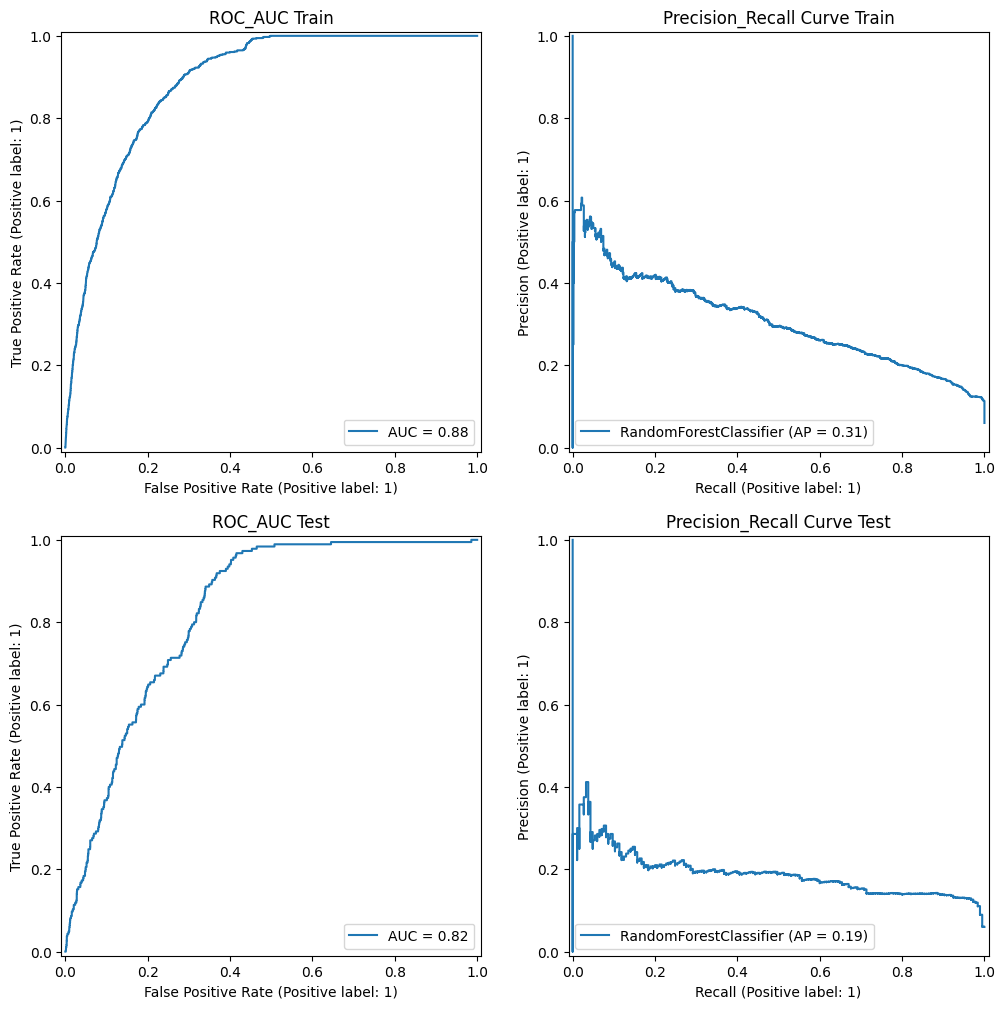

In [23]:
fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=2, figsize=(12, 12))
roc_tr_plot.plot(ax=ax1[0])
ax1[0].set_title('ROC_AUC Train')
prc_tr_plot.plot(ax=ax1[1])
ax1[1].set_title('Precision_Recall Curve Train')

roc_ts_plot.plot(ax=ax2[0])
ax2[0].set_title('ROC_AUC Test')
prc_ts_plot.plot(ax=ax2[1])
ax2[1].set_title('Precision_Recall Curve Test')

plt.show()

Very hard to obtain a balanced precision and recall due to huge class imbalance even with tuned sampler and classifier parameters. A better alternative is to use a better model like XGBoost or LightBoost.

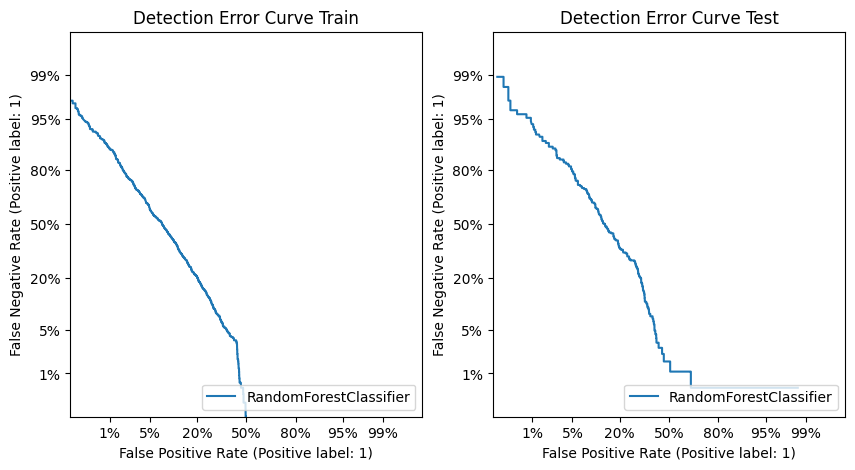

In [24]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))
dt_tr_plot.plot(ax=axs[0])
axs[0].set_title('Detection Error Curve Train')
dt_ts_plot.plot(ax=axs[1])
axs[1].set_title('Detection Error Curve Test')

plt.show()


Confusion matrix

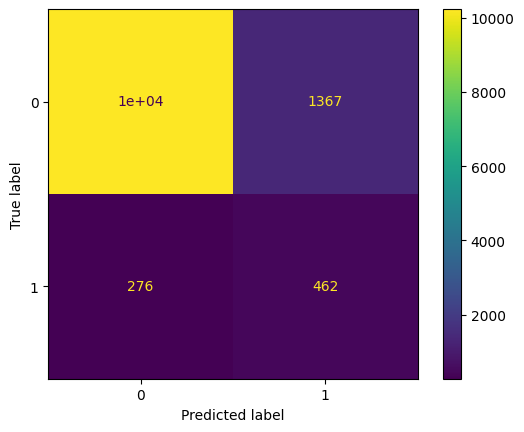

In [25]:
cm_train = confusion_matrix(y_train_enc, pred_train)
ConfusionMatrixDisplay(cm_train).plot()
plt.show()

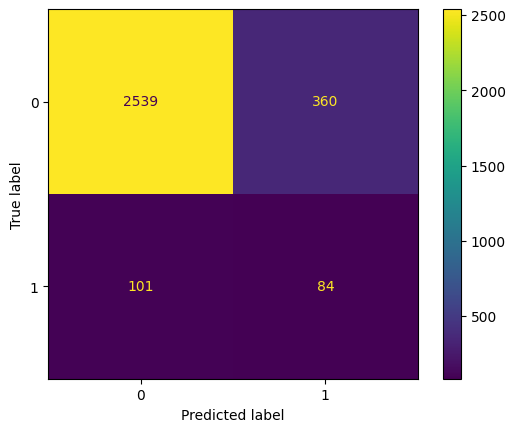

In [26]:
cm_test = confusion_matrix(y_test_enc, pred_test)
ConfusionMatrixDisplay(cm_test).plot()
plt.show()

Dump

In [27]:
joblib.dump(pipeline, 'rf_pipeline.joblib')

['rf_pipeline.joblib']